In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision

import os
import argparse
import pandas as pd

from models.densenet import *

In [2]:
from utils_modis import *

In [3]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import random

----------------------------

In [5]:
device = torch.device('cuda:2') if torch.cuda.is_available() else 'cpu'
best_loss = 100  # best test accuracy
start_epoch = 0

---------------------------------------------------
### Data Preparing

In [6]:
print('==> Preparing data..')

==> Preparing data..


In [7]:
feature_path = './data/MODIS_R2019_2021_95clear_128x128_latents_std.h5'
label_path = './data/MODIS_SSL_v4.parquet'
file_id = 's3://modis-l2/PreProc/MODIS_R2019_2021_95clear_128x128_preproc_std.h5'

In [8]:
batch_size = 256

In [9]:
train_loader = modisdt_loader(feature_path, label_path, file_id, batch_size, 'train')
test_loader = modisdt_loader(feature_path, label_path, file_id, batch_size, 'test')

--------------------------------------------
### Model

In [10]:
print('==> Building model..')

==> Building model..


In [11]:
# Model
net = densenet_fs()
net = net.to(device)

In [12]:
if device == torch.device('cuda:2'):
    net = torch.nn.DataParallel(net, device_ids=[2])
    cudnn.benchmark = True

In [13]:
criterion = nn.MSELoss()

In [14]:
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)

In [15]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2)

In [16]:
exp_dir = os.path.join("./experiments/modisdt_dense_reg", f"lr_{1e-3}")
if not os.path.isdir(exp_dir):
    os.makedirs(exp_dir)

------------------------------------------------
### Train and Evaluation

In [17]:
def train(epoch, visual_use=False):
    print('\nTrain Epoch: %d' % epoch)
    net.train()
    train_loss, steps_train = 0, 0
    loss_history_train = []
    for inputs, targets in tqdm(train_loader):
        steps_train += 1
        inputs = inputs.view(-1, 1, 16, 16).contiguous()
        targets = targets.view(-1, 1).contiguous()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if steps_train // 100 == 0:
            loss_history_train.append(train_loss / steps_train)
        #template_print = 'Step(train): {:d} Loss: {:.3f}'
        #print(template_print.format(steps_train, train_loss / steps_train))
    if visual_use:
        train_dict = {'train_loss': train_loss / steps_train}
        #experiment.log_metrics(train_dict, epoch=epoch)
    template_print = 'Epoch(train): {:d} Loss: {:.3f}'
    print(template_print.format(epoch, train_loss / steps_train))
    return loss_history_train

In [18]:
def test(epoch, visual_use=False):
    global best_loss
    print('\nTest Epoch: %d' % epoch)
    net.eval()
    test_loss, steps_test = 0, 0
    loss_history_test = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            steps_test += 1
            inputs = inputs.view(-1, 1, 16, 16).contiguous()
            targets = targets.view(-1, 1).contiguous()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            if steps_test // 100 == 0:
                loss_history_test.append(test_loss / steps_test)
        if visual_use:
            test_dict = {'test_loss': test_loss / steps_train}
            #experiment.log_metrics(test_dict, epoch=epoch)
    template_print = 'Epoch(test): {:d} Loss: {:.3f}'
    print(template_print.format(epoch, test_loss / steps_test))
    
    # Save checkpoint
    if test_loss < best_loss:
        print('Saving...')
        state = {
            'net': net.state_dict(),
            'loss': test_loss, 
            'epoch': epoch
        }
        check_dir = os.path.join(exp_dir, 'ckpt.pth')
        torch.save(state, check_dir)
        best_loss = test_loss
    return loss_history_test

In [19]:
def prediction(feature_sample):
    print('\nPrediction...')
    net.eval()
    with torch.no_grad():
        feature_sample_reshaped = feature_sample.view([-1, 1, 16, 16]).contiguous()
        feature_sample_reshaped.to(device)
        label = net(feature_sample_reshaped)
    label = label.cpu()
    return label

---------------------------
### Main

In [20]:
if __name__ == '__main__':
    seed = 314
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    start_epoch = 1
    num_epochs = 3
    loss_train_history, loss_test_history = [], []
    for epoch in range(start_epoch, start_epoch+num_epochs):
        loss_train_history_epoch = train(epoch)
        loss_train_history += loss_train_history_epoch
        loss_test_history_epoch = test(epoch)
        loss_test_history += loss_test_history_epoch
        scheduler.step()


Train Epoch: 1


  0%|          | 0/1354 [00:00<?, ?it/s]

Epoch(train): 1 Loss: 0.076

Test Epoch: 1


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch(test): 1 Loss: 0.052
Saving...

Train Epoch: 2


  0%|          | 0/1354 [00:00<?, ?it/s]

Epoch(train): 2 Loss: 0.045

Test Epoch: 2


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch(test): 2 Loss: 0.046
Saving...

Train Epoch: 3


  0%|          | 0/1354 [00:00<?, ?it/s]

Epoch(train): 3 Loss: 0.039

Test Epoch: 3


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch(test): 3 Loss: 0.047


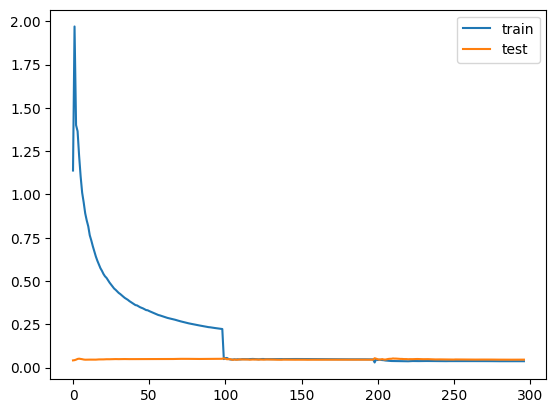

In [30]:
plt.plot(loss_train_history, label='train')
plt.plot(loss_test_history, label='test')
plt.legend()

------------------------------------
#### Prediction

In [22]:
samples_test = next(iter(test_loader))

In [23]:
label_pred = prediction(samples_test[0])


Prediction...


In [24]:
label_true = samples_test[1]

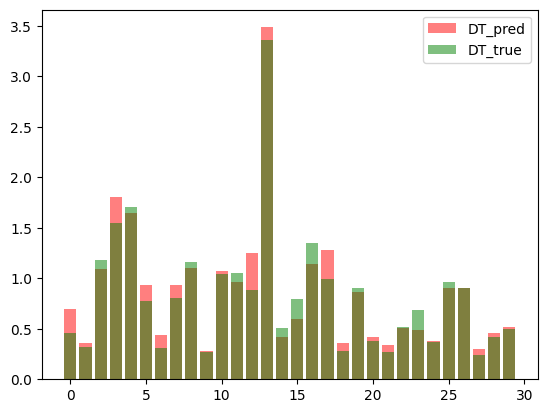

In [27]:
plt.bar(range(30), label_pred[40:70].squeeze(1).cpu(), color='red', alpha=0.5, label='DT_pred')
plt.bar(range(30), label_true[40:70], color='green', alpha=0.5, label='DT_true')
plt.legend()